# Lists, Arrays, and Wishful Thinking
By David Michelman

## Introduction

Most programming languages have constructs called arrays. Unlike normal variables, they can contain multiple elements, and the specific element being referenced can be chosen with another variable. This allows code to be far more extensible. While not technically necessary to a turing complete programing language, they do greatly simplify programs.

However, for whatever reason, the makers of python decided not to include arrays. They instead built in lists, which while similar to arrays, have a few key differences. Arrays need to be given the maximum number of elements they can hold before they are created, while lists can expand infinitely. An element can be put into the nth slot of an array even if the rest is empty while the first n-1 slots in a list need to be filled in a list before an element can be put in the nth slot. Arrays can also be multi-dimensional while lists are one dimensional (although lists can be put inside other lists to emulate multi-dimensional lists).

However, just because python doesn't natively support arrays doesn't mean that they can't be used in python. The library Numpy provides c-like arrays which act in all the ways arrays normally would. They are multi-dimensional, can't be resized, and are extremely fast.

This inquiry's goal is to answer the question "is there a significant style difference between python code which makes heavy use of numpy arrays and python code that doesn’t". The rationale for a style difference being present would be that programmers coming from other languages, and therefore note familiar with python's very specific style guidelines, would be more familiar with numpy arrays than lists and more likely to use arrays.

The 18 python projects examined in this inquiry were taken from Github’s list of the most forked python projects.

The python projects that were used in this study can be found here. They are the most forked python projects as reported by Github.
https://github.com/odoo/odoo.git,
https://github.com/django/django.git, 
https://github.com/scikit-learn/scikit-learn.git, 
https://github.com/mitsuhiko/flask.git,
https://github.com/ansible/ansible.git,
https://github.com/scrapy/scrapy.git,
https://github.com/vinta/awesome-python.git,
https://github.com/tornadoweb/tornado.git,
https://github.com/kennethreitz/requests.git,
https://github.com/rg3/youtube-dl.git,
https://github.com/saltstack/salt.git,
https://github.com/wbond/package_control_channel.git,
https://github.com/udacity/fullstack-nanodegree-vm.git,
https://github.com/ipython/ipython.git'
https://github.com/josephmisiti/awesome-machine-learning.git,
https://github.com/pydata/pandas.git,
https://github.com/reddit/reddit.git,
https://github.com/XX-net/XX-Net.git,
https://github.com/midgetspy/Sick-Beard.git

Some of these projects are quite substantial (like django) and others contain almost no code at all. The repositories awesome-machine-learning and awesome-python are merely curated lists of awesome machine learning and python libraries instead of code themselves.

In [14]:
%matplotlib inline
# the package requests has many outliers which effect analasys. 
# If ignore_requests is set to True then it will not be imported.
ignore_requests = False

The following code was used to download and turn the data into a csv file.

In [15]:
import subprocess
import numpy as np
import csv
import copy
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import collections


# # list of repositories to download. These are the first n most forked repositories with a few exceptions.\
# repository_urls = ()


# def download_repo(url):
#     print('starting')
#     print(subprocess.Popen("git clone " + url, shell=True, stdout=subprocess.PIPE).stdout.read())
#     print('done')

# download_repo(repository_urls[0])

files_processed = list()
header = list()
header.append('file_name')
header.append('file_length')
header.append('import statements')
header.append('pep checker score')

files_processed.append(header)

root_path = '/home/david/big_data_git_downloads/'


def main():
    file_list = open('/home/david/big_data_git_downloads/file_list.txt', mode='r')
    print('file name, number of lines, pep violations, imports')
    for file in file_list:
        analyze_file(file)


def analyze_file(file):
    print(file[2:].replace('\n', ''), end=', ')
    try:
        print(file_length(file), '', end=', ')
        print(run_pep(file), end=', ')
        imports = read_imports(file)
        for imp in imports:
            print(imp.replace('\n', '').replace(',', ''), end=' ')
    except UnicodeDecodeError as e:
        print('error decoding file, ' + str(e).replace('\n', '\\n'))
    print()


def run_pep(file):
    output = subprocess.Popen(["/home/david/anaconda3/bin/pep8", root_path +
                               file[2:-1]], stdout=subprocess.PIPE).communicate()[0]
    output = output.decode("utf-8")
    # Use a regular expression to find all line ends in pep8 output
    pep_violations = output.split('\n')
    pep_violations_filtered = list()
    for line in pep_violations:
        if line.count('E501') == 0 and len(line) > 2:  # to remove blank lines
            pep_violations_filtered.append(line)

    n_errors = len(pep_violations_filtered)
    return n_errors


def read_imports(file):
    current_file = open(root_path + file[2:-1], mode='r')
    packages = list()

    for line in current_file:
        line_components = line.split(' ')

        if len(line_components) < 2:
            pass
        elif line_components[0] == 'import':
            if line_components[-2] != 'as':
                for package in line_components[1:]:
                    package = package.replace('(', '').replace(')', '')
                    package = package.replace(',', '').replace('\n', '')
                    packages.append(package)
            else:
                for package in line_components[1:-2]:
                    package = package.replace('(', '').replace(')', '')
                    package = package.replace(',', '').replace('\n', '')
                    packages.append(package)
        elif line_components[0] == 'from':
            if line_components[-2] != 'as':
                parent_package = line_components[1]
                for package in line_components[3:]:
                    package = package.replace('(', '').replace(')', '')
                    package = package.replace(',', '').replace('\n', '')
                    packages.append(parent_package + '.' + package)
            else:
                parent_package = line_components[1]
                for package in line_components[3:-2]:
                    package = package.replace('(', '').replace(')', '')
                    package = package.replace(',', '').replace('\n', '')
                    packages.append(parent_package + '.' + package)

    return packages


def file_length(file):
    current_file = open(root_path + file[2:-1], mode='r')
    count = 0
    for line in current_file:
        count += 1
    return count


This next section contains useful functions that aren't specific to this dataset in any way.

In [16]:
def bar_graph(data_array, index_x, index_y, title, y_title, headers):
    """
    Shows a plot of the passed data, plt.show() must be called after all calls of bar_graph()
    :param data_array: data array (must be 2 dimensional)
    :param index_x: Coordinates for x axises (in form [x axis 1, x axis 2, x axis 3, ... x axis n]
    :param index_y: Coordinates for Y axis
    :param title: Title of graph
    :param y_title: Y axis title
    :param headers: the labels for the data
    :return: None
    """
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    # create list of all unique values in x_index

    x_values = find_unique_values(data_array, index_x[0])

    # The following code is from the matplotlib api reference.
    # It can be found here: http://matplotlib.org/examples/api/barchart_demo.html

    averages = list()
    for axis in index_x:
        averages.append(filtered_average(data_array, index_y, [axis, ]))

    ind = np.arange(len(index_x))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects = list()
    for i in range(len(averages)):
        rects.append(ax.bar(ind, i, averages[i], color='r', yerr=1))

    # add some text for labels, title and axes ticks

    ax.set_xticks(ind + width)
    ax.set_xticklabels(headers)

    ax.legend(rects, ('Men', 'Women'))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects)

    ax1.set_title(title + ')\n')
    ax1.set_ylabel(y_title)


def find_unique_values(data, axis):
    values = set()
    for i in data[axis]:
        values.update(i)
    return list(values)


def scatter_plot(data_array, index_x, index_y, title, x_title, y_title, compute_best_fit=False, square_axes=False) -> None:
    """
    Shows a plot of the passed data, plt.show() must be called after all calls of scatter_plot()
    :param data_array: data array (must be 2 dimensional)
    :param index_x: Coordinates for x axis or array with x data or array of x data
    :param index_y: Coordinates for Y axis or array with y data or array of y data
    :param title: Title of graph
    :param x_title: X axis title
    :param y_title: Y axis title
    :param compute_best_fit: Should a best fit line be computed? (boolean)
    :param square_axes: Forces axes to be square
    :return: None
    """
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    if isinstance(index_x, collections.Iterable):
        x_indices = index_x
        y_indices = index_y
    else:
        x_indices = data_array[index_x]
        y_indices = data_array[index_y]

    if compute_best_fit:
        sorted = list()
        if not isinstance(index_x, collections.Iterable):
            for i in range(data_array.shape[1]):
                if not (math.isnan(data_array[index_x][i]) or math.isnan(data_array[index_y][i])):
                    sorted.append([data_array[index_x][i], data_array[index_y][i]])
        else:
            for i in range(len(x_indices)):
                sorted.append([x_indices[i], y_indices[i]])

        # this line comes from Stephen on stack exchange
        # (http://stackoverflow.com/questions/3121979/how-to-sort-list-tuple-of-lists-tuples)
        sorted.sort(key=lambda tup: tup[1])

        x = list()
        y = list()
        for i in sorted:
            x.append(i[0])
            y.append(i[1])

        # the next 3 lines come from DSM on stack exchange
        # (http://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)
        ax1.plot(x, y, 'yo', x, fit_fn(x), '--k')

        if not isinstance(index_x, collections.Iterable):
            ax1.set_title(title + '\n (correlation coefecient = '
                          + str(pearsonr_filtered(data_array[index_x], data_array[index_y])[0])
                          + ', regression slope = ' + str(fit_fn[1]) + ')\n')
        else:
            ax1.set_title(title + '\n (correlation coefecient = '
                          + str(stats.pearsonr(x_indices, y_indices)[0])
                          + ', regression slope = ' + str(fit_fn[1]) + ')\n')

    else:
        ax1.scatter(x_indices, y_indices)
        ax1.set_title(title + '\n')
    if square_axes:
        ax1.axis('equal')
        ax1.axis([0, np.amax(x_indices) + 1, 0, np.amax(y_indices) + 1])
    ax1.set_xlabel(x_title)
    ax1.set_ylabel(y_title)


def filtered_average_stdev(data, target, constraints, meets_constraint = False, contains=False, return_data=False):
    """
    Calculates the average of columns in the passed numpy array data which meet some constraint
    :param data: data array (must be 2 dimensional)
    :param constraints: columns which must equal some value (in form [[0, 2013], [3, FAIL]], which means
                        column 0 must equal 2013 and column 3 must equal FAIL).
    :param target: column to be averaged
    :param contains: if the constraint must only be contained in the line of data, not equal to the line of data
    :return: average value
    """

    scores = list()
    for line in range(data.shape[1]):
        failed = True
        for rule in constraints:
            if not contains and data[rule[0], line] == rule[1]:
                failed = False
            if contains and rule[1] in data[rule[0], line]:
                failed = False
        if failed is False:
            try:
                scores.append(float(data[target, line]))
            except ValueError as e:
                pass  # data[target, line] probably can't be turned into a float
    try:
        if not return_data:
            return np.average(scores), np.std(scores)
        else:
            return scores
    except ZeroDivisionError:
        raise ZeroDivisionError(
            'no float data fit constraints in filtered_average([data], ' + str(target) + ' ' + str(constraints))


def print_correlation_array(data, headers):
    """
    Prints a matrix of the correlations between all different variables
    :param data: data array
    :param headers: array of header values
    :return: None
    """

    # TODO: make header_length changeable without messing up formatting

    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

    # Make copy of headers then make them all the same length
    headers_full = headers
    headers = copy.deepcopy(headers)
    header_length = 9
    for i in range(len(headers)):
        if len(headers[i]) > header_length:
            headers[i] = headers[i][0:header_length]
        while len(headers[i]) < header_length:
            headers[i] += ' '
    max_length = 0
    for i in headers_full:
        if len(i) > max_length:
            max_length = len(i)
    for i in range(len(headers_full)):
        while len(headers_full[i]) < max_length:
            headers_full[i] += ' '

    # first z dimension is z values, second z dimension is p values
    corelation_array = np.zeros([data.shape[0], data.shape[0]], dtype=np.float64)

    for i in range(corelation_array.shape[0]):
        for j in range(corelation_array.shape[1]):
            if j < i:
                corelation_array[i][j] = pearsonr_filtered(data[i], data[j])[0]
            else:
                corelation_array[i][j] = -2.0

    coloring_bound_upper = 0.5
    coloring_bound_lower = 0.3
    for i in range(len(headers_full[0])):
        print(' ', end='')
    print(HEADER + "      " + str(headers[0:-1]).replace("', '", ' ').replace("('", '').replace("['", '').replace("']",
                                                                                                                  '') + ENDC)
    for i_num in range(1, len(corelation_array)):
        if i_num < 10:
            print(' ', end='')
        print(HEADER + str(i_num) + ' ' + headers_full[i_num] + ENDC, end='')
        i = corelation_array[i_num]
        for j_num in range(len(i) - 1):
            j = i[j_num]
            if j_num > i_num - 1:
                if j_num > i_num:
                    print('    |     ', end='')
                else:
                    print('    \u25BC     ', end='')  # the escape code is for a triangle pointing down
            elif math.isnan(j):
                print('   nan   ', end=' ')
            elif j >= 0:
                if 1.0 > abs(j) > coloring_bound_upper:
                    print(OKGREEN + '   ' + '%.4f' % j + ENDC, end=' ')
                elif 1.0 > abs(j) > coloring_bound_lower:
                    print(OKBLUE + '   ' + '%.4f' % j + ENDC, end=' ')
                else:
                    print('   ' + '%.4f' % j, end=' ')
            else:
                if 1.0 > abs(j) > coloring_bound_upper:
                    print(OKGREEN + '  ' + '%.4f' % j + ENDC, end=' ')
                elif 1.0 > abs(j) > coloring_bound_lower:
                    print(OKBLUE + '   ' + '%.4f' % j + ENDC, end=' ')
                else:
                    print('  ' + '%.4f' % j, end=' ')
        print('   ' + HEADER + str(i_num) + ' ' + headers_full[i_num] + ENDC)
    print('\n')


def pearsonr_filtered(x, y):
    # remove any nan values from x and y
    x = list(copy.deepcopy(x))
    y = list(copy.deepcopy(y))

    initial_len = len(x)

    # a while loop is used instead of a for loop because the list of x changes during loop execution
    i = 0
    while i < len(x):
        try:
            if math.isnan(float(x[i])) or math.isnan(float(y[i])):
                x.pop(i)
                y.pop(i)
                i -= 1
        except ValueError as e:
            x.pop(i)
            y.pop(i)
            i -= 1
        except TypeError as e:
            x.pop(i)
            y.pop(i)
            i -= 1

        i += 1

    if len(x) < initial_len / 4.0:
        # There was not enough numerical data to do proper analysis on
        return math.nan, math.nan
    return stats.pearsonr(np.array(x).astype(np.float), np.array(y).astype(np.float))

The code that imports our data from a csv file:

In [17]:
raw_file = open('code_data.txt', mode='r')
headers = raw_file.readline().replace('\n', '').split(',')
data_list = list()
for line in raw_file:
    if line.count(', error ') == 0 and len(line) > 3:  # make sure line is not blank or an error
        line_components = line.replace('\n', '').split(',')
        if (not ignore_requests) or line_components[0].find('requests') == -1:
            data_list.append(list(line_components))
    else:
        # an error occurred in processing this file
        pass

# headers for calculated statistics are added here
headers.append('np*n_lines')
headers.append('pep_violations/n_lines')

data = np.zeros([len(headers), len(data_list)], dtype=object)

for line_n in range(len(data_list)):
    line_components = data_list[line_n]
    for i in range(len(line_components)):
        line_data = str(line_components[i])
        try:
            data[i][line_n] = float(line_data)
        except ValueError:
            data[i][line_n] = line_data

# calculated statistics are added here
for i in range(data.shape[1]):
    # fill column 5 with if numpy was imported * file length
    data[4][i] = max(data[3][i].count('numpy'), 1) * int(data[1][i])
    try:
        data[5][i] = int(data[2][i]) / int(data[1][i])
    except ZeroDivisionError:
        data[5][i] = 0


And now that we're here, why don't we look at the 20 most imported packages?

In [18]:
package_dict = dict()
for i in range(data.shape[1]):
    for package_name in data[3][i].split(' '):
        if len(package_name) > 2:
            if package_dict.get(package_name) is not None:
                package_dict[package_name] += int(data[1][i])
            else:
                package_dict[package_name] = int(data[1][i])

counts = list([0])
word = list(['not_a_real_package'])

for key in package_dict:
    n_occur = package_dict[key]

    for i in range(len(counts)):
        if n_occur > counts[i]:
            counts.insert(i, n_occur)
            word.insert(i, key)
            break
        else:
            i += 1

for i in range(15):
    print('package ' + str(word[i]) + ' was used by ' + str(counts[i]) + ' lines')

package __future__.absolute_import was used by 726616 lines
package sys was used by 596065 lines
package logging was used by 574737 lines
package numpy was used by 421108 lines
package time was used by 414441 lines
package salt.utils was used by 328730 lines
package datetime was used by 307202 lines
package warnings was used by 300232 lines
package __future__.unicode_literals was used by 292266 lines
package __future__.print_function was used by 278575 lines
package datetime.datetime was used by 265247 lines
package salt.ext.six was used by 257164 lines
package json was used by 224485 lines
package pandas.compat was used by 181403 lines
package copy was used by 176894 lines


Wow, only sys and logging were used more than numpy! Numpy appears to be off to a good start.

An important fine point is that this code counts the number of lines of each file that imports numpy. This is to remove any competitive advantage that would come from breaking code up into multiple files then importing numpy separately in each file.


And now we print the correlation array.

In [19]:
print_correlation_array(data, headers)

                            file name  number o  pep viol  imports  np*n_line
 1  number of lines         nan        ▼         |         |         |        1  number of lines      
 2  pep violations          nan       0.2557     ▼         |         |        2  pep violations       
 3  imports                 nan       nan       nan        ▼         |        3  imports              
 4 np*n_lines               nan       0.8148    0.1581    nan        ▼        4 np*n_lines            
 5 pep_violations/n_lines   nan       0.0209    0.7628    nan       0.0096    5 pep_violations/n_lines




Nothing in this section is too surprising. There is strong correlation between the length of a file and the number of lines in a file that have access to numpy as well as the number of pep violations in a file and the number of pep violations per line. These are both to be expected because both of these are mathematically related (pep violations per line = total number of pep violations / number of lines). The other variables are generally very weakly correlated.

And now we make a few scatter plots.

<IPython.core.display.Javascript object>


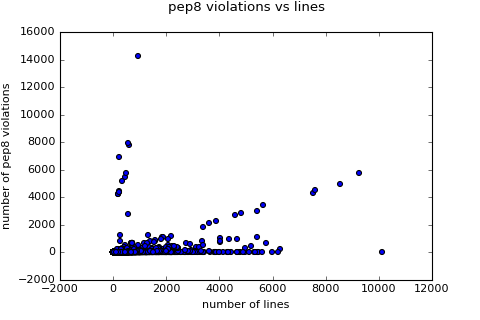

<IPython.core.display.Javascript object>


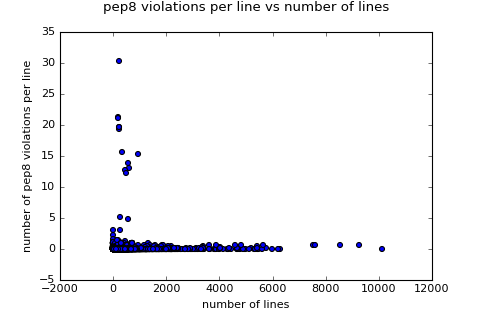

<IPython.core.display.Javascript object>


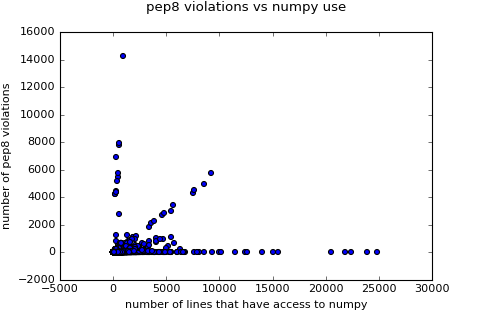

In [20]:
scatter_plot(data, 1, 2, 'pep8 violations vs lines', 'number of lines', 'number of pep8 violations')
scatter_plot(data, 1, 5, 'pep8 violations per line vs number of lines', 'number of lines',
             'number of pep8 violations per line')
scatter_plot(data, 4, 2, 'pep8 violations vs numpy use', 'number of lines that have access to numpy',
             'number of pep8 violations')

The first and third plots are interesting because there appear to be multiple linear sections in the data. On first inspection these could be different styles of coding.

the following packages were found {'tornado', 'ansible', 'youtube-dl', 'awesome-python', 'salt', 'Sick-Beard', 'fullstack-nanodegree-vm', 'package_control_channel', 'XX-Net', 'scikit-learn', 'odoo', 'ipython', 'django', 'flask', 'pandas', 'reddit', 'scrapy', 'awesome-machine-learning', 'requests'}
5795.0


<IPython.core.display.Javascript object>


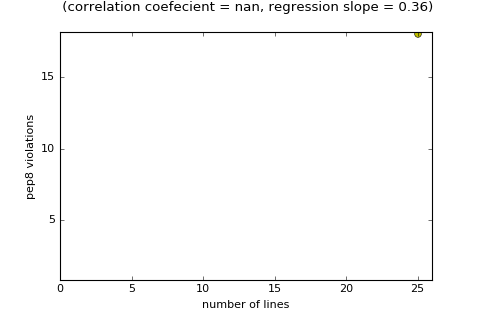

/home/david/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/home/david/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2542: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


<IPython.core.display.Javascript object>


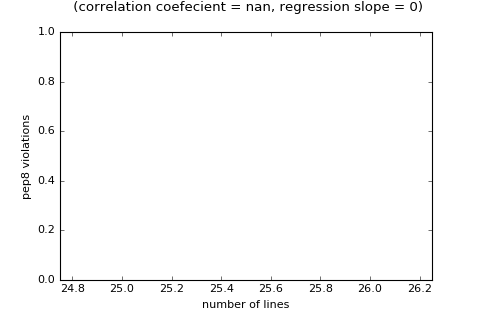

/home/david/anaconda3/lib/python3.5/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>


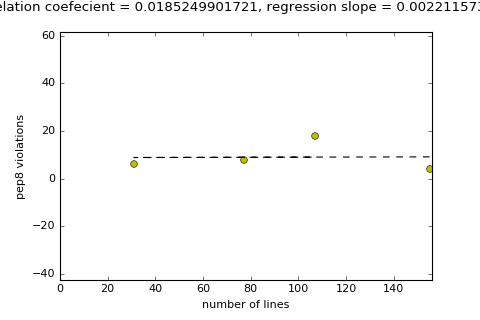

<IPython.core.display.Javascript object>


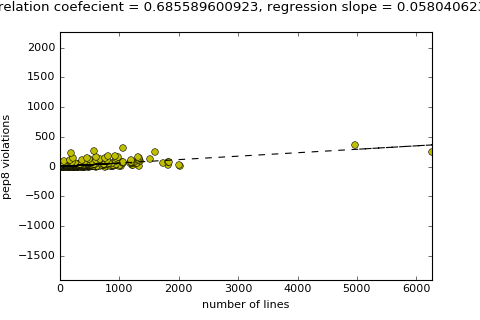

<IPython.core.display.Javascript object>


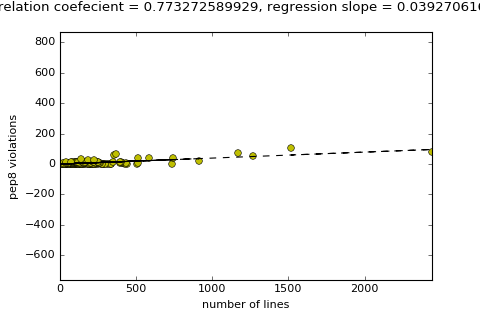

<IPython.core.display.Javascript object>


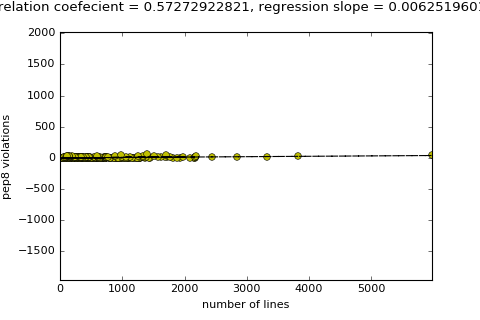

<IPython.core.display.Javascript object>


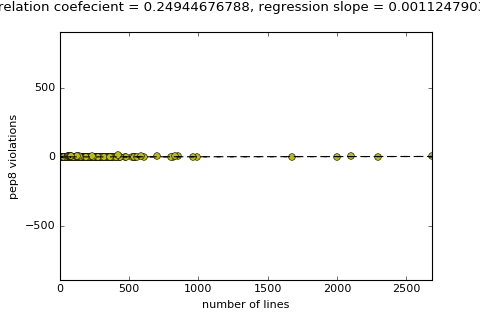

<IPython.core.display.Javascript object>


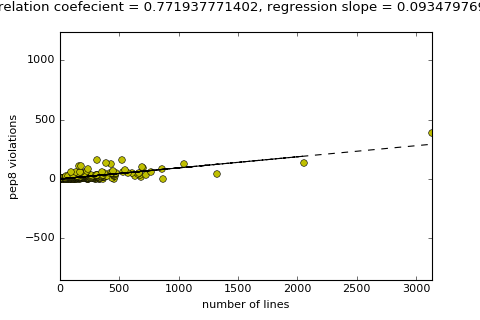

<IPython.core.display.Javascript object>


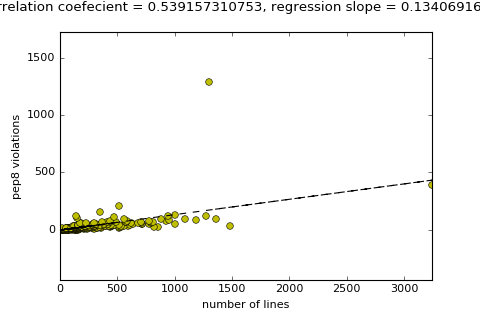

<IPython.core.display.Javascript object>


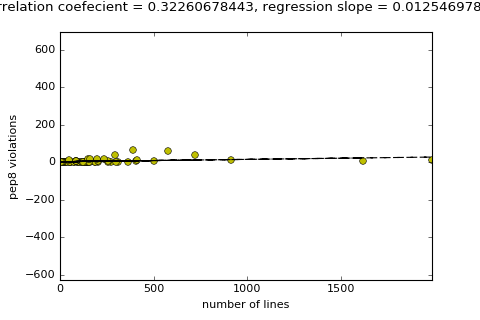

<IPython.core.display.Javascript object>


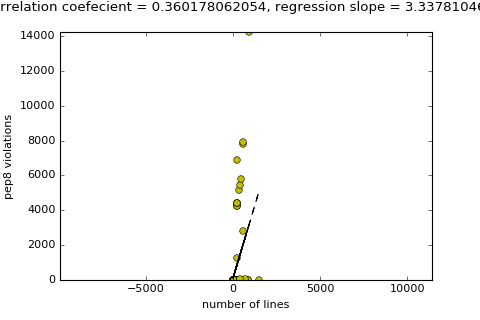

<IPython.core.display.Javascript object>


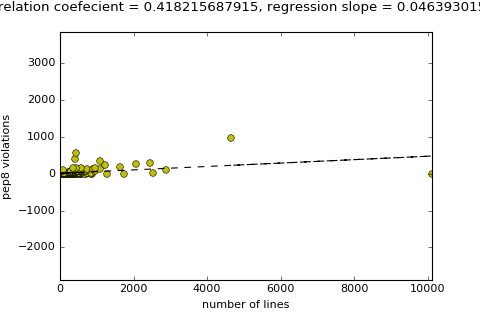

<IPython.core.display.Javascript object>


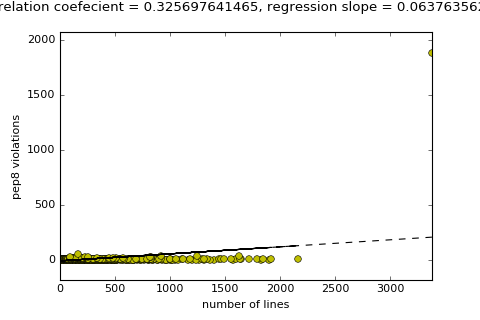

<IPython.core.display.Javascript object>


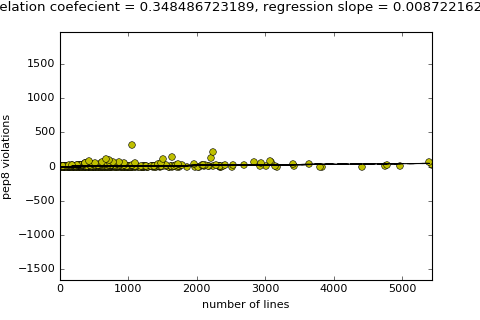

<IPython.core.display.Javascript object>


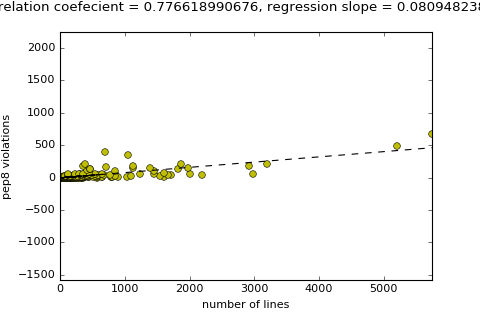

<IPython.core.display.Javascript object>


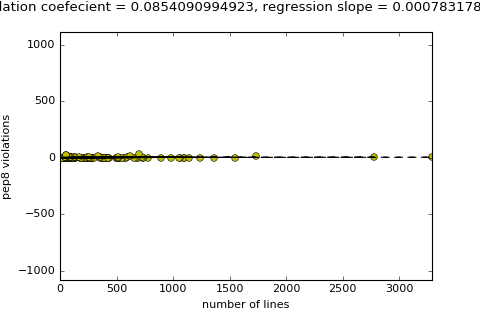

<IPython.core.display.Javascript object>


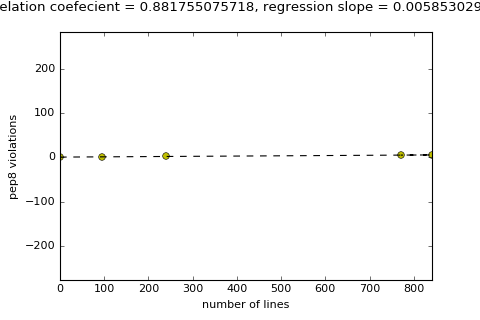

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


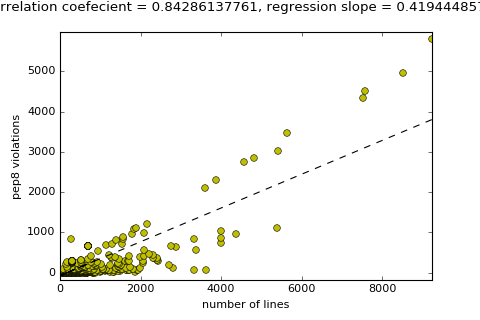

<IPython.core.display.Javascript object>


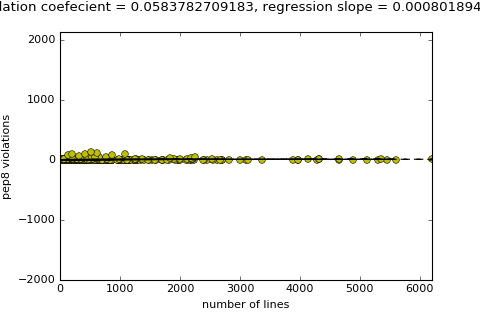

In [21]:
package_names = set()
for i in range(data.shape[1]):
    package_names = package_names | set([data[0][i].split('/')[0]])

names_np = list()
for name in package_names:
    names_np.append([name, float(filtered_average_stdev(data, 4, [[0, name]], contains=True)[0])])
    
    
names_np.sort(key=lambda tup: tup[1])

print('the following packages were found', package_names)

# This line prints out the maximum value in the dataset. It is extremely usefull 
# for finding points on graphs in the raw data.
print(np.array(filtered_average_stdev(data, 2, [[0, 'XX-Net']], contains=True, return_data=True)).max())

x = list()
y = list()
for name_foo in names_np:
    name = name_foo[0]
    foobars = filtered_average_stdev(data, 5, [[0, name]], contains=True)
    x.append(foobars[0])
    y.append(foobars[1])
    
    scatter_plot(data, filtered_average_stdev(data, 1, [[0, name]], contains=True, return_data=True),
                filtered_average_stdev(data, 2, [[0, name]], contains=True, return_data=True),
                'pep8 violations vs number of lines in package "' + name + '"\n(' + 
                str(filtered_average_stdev(data, 4, [[0, name]], contains=True)[0]) + ' np imorts*lines)', 
                 'number of lines', 'pep8 violations', compute_best_fit = True, square_axes=True)


The previous graphs show the number lines in each python fine in a project against the number of pep8 violations. The graphs are ordered by the number of lines with access to numpy (numerically the sum of the number of lines in each file where numpy is imported). There doesn't seem to be a clear trend in coding errors per line as numpy usage increases. 

These graphs also confirm our previous speculation that some python projects have distinct pep8 error/line ratios. Next we will actually look at the code analyzed here to see if the styles are actually different.

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


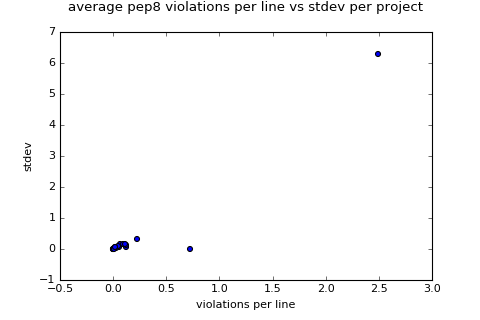

In [22]:
scatter_plot(data, x, y, 'average pep8 violations per line vs stdev per project', 'violations per line', 'stdev')

Just for reference, this is a scatter plot of the average number of pep8 violations per line versus the standard deviation of the number of pep8 violations per line. There is one project that has about 0.7 violations per line but a very low standard deviation, so it probably uses a document other than pep for its style guidelines.

So can pep8 scores be an indicator of coding style? The answer appears to be sort of. If we look at the file gae_proxy/server/lib/google/appengine/datastore/datastore_v3_pb.py

There are a few points of interest in this file. The first is that indents are only two spaces instead of the usual four. This is responsible for a large portion the pep8 violations this particular file generates. There are also single line methods, such as "def has_handle(self): return self.has_handle_", which also cause pep8 violations. This is a clear example of an alternate coding style generating pep8 errors.

The most obvious outlier comes from the package requests (which handles http communications). Part of the file requests/packages/chardet/big5freq.py is shown below.

While this formatting makes sense in the context where it is being used, it doesn't follow the official python style guidelines and so has a very pour pep8 score. There are technically supposed to be spaces after every comma, even though that would hurt readability in this context. Each of the comments at the end of the lines are also responsible for pep8 violations because they don't have the correct number of spaces after the '#' symbol. 

While this particular file has 15095 pep8 violations and only 925 lines it isn't really unique. There are many other files in the same directory, such as langhungarianmodel.py and langcyrillicmodel.py, which are similarly formatted. The rest of the code in this project appears to be properly formatted.

# Conclusion

Sadly enough, there doesn’t appear to be any correlation between Numpy use and coding style. Not only was the statistical correlation between Numpy usage and the number of pep8 violations incredibly small (0.158), but visuals didn’t reveal any noticeable trends either. 

However, the correlation between the number of lines in a file and the number of pep8 violations was also quite small (0.256) which implies that the number of pep8 violations in a file is very weakly correlated with the length of a file, meaning that some programmers do in fact have different coding styles than others. While this could also mean that some programmer are simply worse at writing stylistically correct code than others, although I’m assuming that this isn’t the case because the projects I sampled are well known and maintained, so poorly formatted code would probably be quickly fixed or rejected. 

An interesting point is that when the project Requests is omitted from the analysis then the correlation between Numpy usage and the number of pep8 violations becomes 0.303 instead of 0.158 and the correlation between the number of pep violations and the number of lines in a file became 0.488 instead of 0.303. However, this analysis requires the exclusion of data which is an inherent flaw.
